# 카메라 스티커앱 만들기

## Library import
- opencv : 오픈소스 컴퓨터 비전 및 머신러닝 라이브러리
(얼굴 인식, 객체의 3D모델 추출, 좌표 생성, 이미지 스티칭 영상 검색 등 다양한 응용 분야에 이용)
- dlib : 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리

 opencv 와 dlib 는 듣기엔 같은 기능 같으나 얼굴인식에 관한 dlib 가 강력한 기능을 보이고 있으며 (99% 이상이라 한다..)
dlib 의 기능을 사용하기 위한 이미지 처리에 대해서는 opencv 가 많은 역할을 한다.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import os

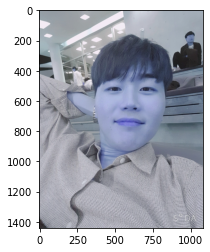

In [2]:
my_image_path = os.getenv('HOME')+ '/aiffel/camera_sticker/images/ohwonjin.jpg'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy() 
plt.imshow(img_bgr)
plt.show()

#matplotlib,dlib에서는 모두 RGB 채널을 사용하는 반면
#opencv에서는 예외적으로 BGR(ble, green, red)의 채널을 사용하기에 푸르게 보임
#따라서 보정처리를 필요로함.

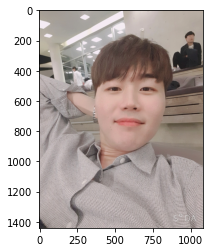

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # BGR 이미지를 RGB 이미지로 변경
plt.imshow(img_rgb)
plt.show()

### imread의 flag설명

- 이미지 읽기의 flag는 1, 0, -1의 값을 갖게됨

- cv2.IMREAD_COLOR (flag=1): 이미지 파일을 Color로 읽어들임. 투명한 부분은 무시되며, Default값임

- cv2.IMREAD_GRAYSCALE (flag=0) : 이미지를 Grayscale로 읽어 들임. 실제 이미지 처리시 중간단계로 많이 사용함.

- cv2.IMREAD_UNCHANGED (flag=-1): 이미지파일을 alpha channel까지 포함하여 읽어 들임

## 얼굴 검출 (face detection)

detector_hog의 두 번째 파라미터는 이미지 피라미드의 수이다. 이미지 피라미드는 upsampling 방법을 통해 크기를 키우는 것으로 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.

 - upsampling이란, 간단하게 데이터의 크기를 키우는 것
 
 일반적으로 CNN의 레이어를 통과하면서 이미지의 크기를 줄이는 것을 down sampling이라고 하는데,down sampling의 반대 개념이 upsampling임

dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾는다.

이미지의 색상만 가지고는 SVM이 큰 힘을 발휘하지 못한다. 하지만 이미지가 HOG를 통해 벡터로 만들어진다면 SVM이 잘 작동하게 됨.

- HOG는 이미지에서 색상의 변화량을 나타낸 것

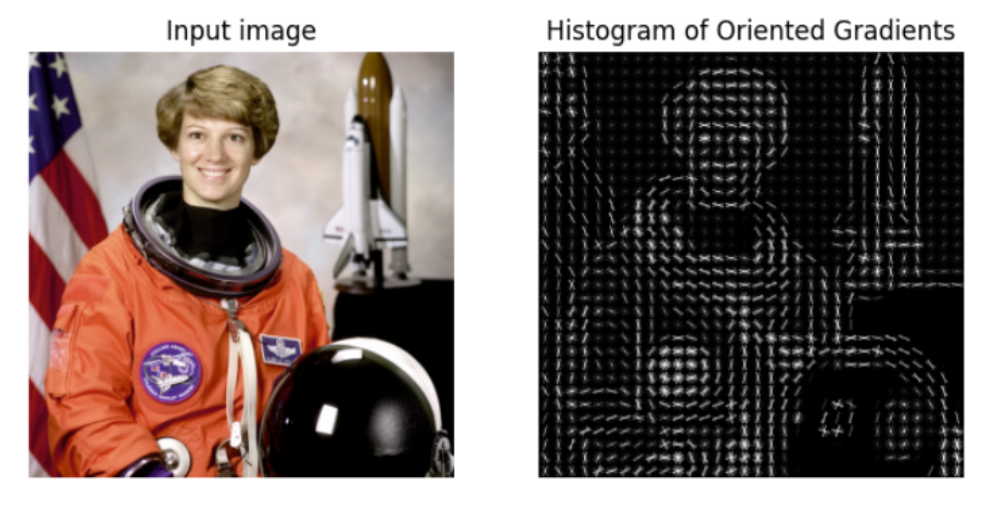

In [4]:
# 디턱테 선언
detector_hog = dlib.get_frontal_face_detector() 

In [5]:
# 디텍터를 이용해서 얼굴의 BOUNDING BOX를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)  # (image, 이미지 피라미드의 수)

- sliding window
 - 작은 영역(window)을 이동해가며 확인하는 방법
 - 큰 이미지의 작은 영역을 잘라 얼굴이 있는지 확인하고, 다시 작은 영역을 옆으로 옮겨 얼굴이 있는지 확인하는 방식

rectangles[[(348, 400) (810, 862)]]


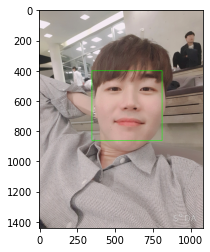

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- dlib detector는 dlib.rectangles 타입의 객체를 반환
- dlib.rectangle 객체는 left(), top(), right(), bottom(), height(), width() 등의 함수를 포함

## 얼굴 랜드마크 (face landmark)

face landmark는 detection의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지를 이용한다.

- 객체 내부의 점을 찾는 기술 object keypoint estimation 알고리즘 2가지

 1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측
 
 2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 예제에서는 1번 방식으로 진행

In [7]:
model_path = 'models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)    
# 저장된 landmark 모델 불러오기

In [8]:
list_landmarks = []
# 얼굴 영역 박스 마다 face landmark를 찾아냄.
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장함.
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
print(list_landmarks[0])


68
[(362, 552), (363, 609), (369, 665), (376, 723), (388, 781), (416, 832), (461, 873), (516, 904), (582, 916), (649, 910), (708, 883), (760, 845), (799, 798), (822, 742), (835, 682), (844, 622), (848, 562), (409, 484), (438, 448), (483, 430), (533, 429), (578, 443), (629, 444), (676, 428), (727, 427), (774, 444), (804, 482), (604, 502), (603, 539), (602, 575), (601, 613), (552, 661), (577, 666), (599, 672), (623, 667), (646, 663), (459, 526), (485, 514), (513, 513), (539, 528), (513, 531), (485, 531), (671, 530), (699, 516), (727, 516), (752, 530), (728, 533), (699, 533), (496, 740), (536, 723), (571, 712), (595, 719), (621, 714), (654, 729), (690, 751), (651, 767), (617, 774), (591, 775), (565, 771), (532, 761), (511, 742), (570, 739), (594, 742), (620, 741), (674, 751), (618, 743), (592, 744), (567, 740)]


- points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있음.
- 따라서, list_points 는 tuple (x, y) 68개로 이루어진 리스트
- 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됨.

(아래 그림 Dlib에 사용 되는 랜드마크 순서 참조)

## landmark 이미지(영상)에 출력

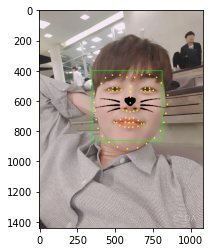

In [18]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 5, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)


plt.imshow(img_show_rgb)
plt.show()

- 아래 그림은 Dlib에 사용 되는 랜드마크 순서
- 점의 갯수는 데이터셋과 논문마다 다름(ibug 300w 데이터셋은 68개를 사용)
- Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 을 제공하고 학습 알고리즘은 regression tree의 앙상블 모델을 사용
- 여기서는 Dlib에서 제공되는 모델을 사용하였다.

[Dlib에 사용 되는 랜드마크 순서]

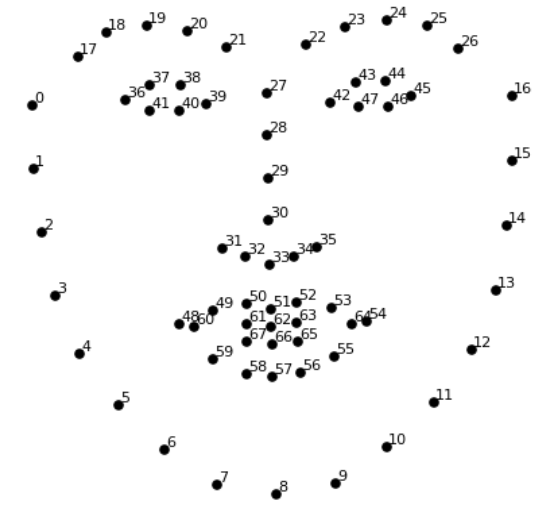

## 스티커 적용

얼굴 위치는 카메라의 거리에 따라 픽셀 x가 다르기에 비율로 아래 방법으로 계산한다.

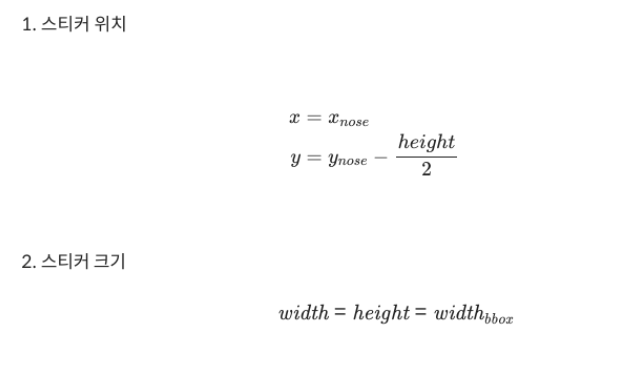

In [10]:
## 고양이 스티커
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0] # left
    y = landmark[30][1] - dlib_rect.height()//2 # top
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print (landmark[30]) # nose center index : 30
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(601, 613)
(x,y) : (601,382)
(w,h) : (463,463)


In [11]:
## 모자 씌우고 싶은 경우 - 스티커의 위치(x, y)와 크기(w, h)를 출력
# for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
#     print (landmark[27]) 
#     x1 = landmark[27][0]
#     y1 = landmark[27][1] - dlib_rect.height()//2
#     w1 = h1 = dlib_rect.width()
#     print ('(x,y) : (%d,%d)'%(x1,y1))
#     print ('(w,h) : (%d,%d)'%(w1,h1))

### 사이즈 조정

(463, 463, 3)


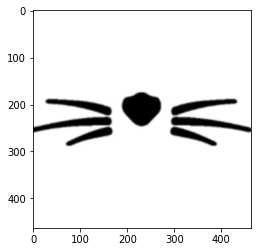

In [12]:
sticker_path = 'images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

- 스티커의 이미지를 읽어온 후, 위에서 계산한 크기(w, h)를 이용하여 스티커를 resize

In [13]:
# 고양이 수염 위치
refined_x = x - w // 2  # left
refined_y = y + 10  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 카우보이 모자 위치
# refined_x1 = x - w // 2   
# refined_y1 = y1 - h1 // 2 - 40 
# print ('(x,y) : (%d,%d)'%(refined_x1, refined_y1))

# 티셔츠 위치
# refined_x2 = x - w // 2   
# refined_y2 = y2 + h2 + 120
# print ('(x,y) : (%d,%d)'%(refined_x2, refined_y2))

(x,y) : (370,392)


- 스티커의 시작점이 얼굴 사진의 영역을 벗어나면 음수로 표현됨.
- opencv 데이터는 numpy ndarray 형태의 데이터를 사용함.
- ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해줘야 함.
- 따라서 그림에서 보는 것처럼 원본 이미지의 범위를 벗어난 스티커 부분을 제거해 주어야 함.

## 원본이미지에 각각의 스티커 이미지 적용

- 길어서 복잡해 보이지만 img_show[from:to] 형식

In [14]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)

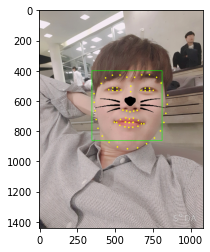

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## bounding box와 landmark를 제거하고 최종 결과만 출력

- 각각의 스티커와 원본이미지 간의 좀더 자연스러운 이미지를 위해 cv2.addWeighted() 적용

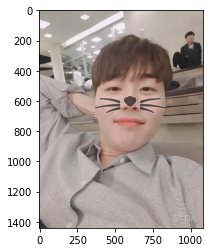

In [16]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.4, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.6, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# cv2.addWeighted() 스티커를 조금 더 자연스럽게 적용하기

## 회고

- 본인의 사진을 배경으로 고양이 수염 스티커 붙이기를 시도하였다.
- 첫번째 시도때, 스티커 배경색이 파란색으로 된걸 저장함으로써 색을 연하게 해도 마지막 사진때 경계선이 지워지지 않음을 확인함
- 이에 사진 배경색도 중요함을 깨닫고 새로운 사진으로 적용함.
- 카우보이 모자와 t-shirt 스티커 붙일때는 위치를 잡는 것에 약간의 애를 먹긴 했지만 정확한 위치에 잘 어울리게 출력되었다.